In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import pickle
import re
from lemmatizer import findPos
from gensim.models import KeyedVectors
import gensim
import turkishnlp
from turkishnlp import detector
from collections import Counter
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import os
#from TurkishStemmer import TurkishStemmer

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

-f


/Applications/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [27]:
data = pd.read_excel("incident son 6 aylk_son2.xlsx")
#data = pd.read_excel("incident son 6 aylk.xlsx")
#data=data.apply(lambda x: x.fillna(''),axis=0)
data = data[['Description','Category','Subcategory']]
data['Category_Last'] =   data['Category']+'-'+data['Subcategory']

In [28]:
#belirli bir thresholdun aşağısında örnek varsa siliniyor
a = {i:sum(data['Category_Last'] == i) for i in (data['Category_Last'].unique())} 
threshold = 50
drops = [x  for x in a if a[x] < threshold ]
multi_  = [data.loc[data['Category_Last'] == idx].index.values.tolist() for idx in drops]
single_ = [val for inner in multi_ for val in inner]
data = data.drop(single_)
data = data.dropna()
data.reset_index(drop=True, inplace=True)

In [29]:
data['Category_Last'].unique().shape

(23,)

In [30]:
categorys = data['Category_Last'].unique() 
numbers = [data[data['Category_Last'] == x].shape[0] for x in categorys]
dict_category = { x:y for x,y in zip(categorys,numbers) }

In [31]:
def remove_same(strr): #acillll kelimesi acil'e dönüştürmek için
    word = ''
    for i in range(len(strr)-1,0,-1):
        j = i-1
        if strr[i] != strr[j]:
            word += strr[i]
        if j == 0 and strr[0] != strr[1]:
            word+=strr[0]
    return word[::-1]
        

In [32]:
with open('corrector.txt',encoding="utf-8") as f:  #kelimeler dict'e dönüştürüldü
    lines = f.readlines()
    vocab = {line.split(',')[0]:line.split(',')[1].split('\n')[0]  for line in  lines }

In [33]:
def convert_partially_tr(strr):
    strr = strr.replace('i','ı')
    strr = strr.replace('ğ','g')
    strr = strr.replace('ö','o')
    strr = strr.replace('ü','u')
    strr = strr.replace('ş','s')
    strr = strr.replace('ç','c')
    return strr

In [34]:
#stemmer = TurkishStemmer()
obj = detector.TurkishNLP() #türkçe bazı kelimelerin düzeltilmesi için
#obj.download()
obj.create_word_set()
old_stdout = sys.stdout 
sys.stdout = open(os.devnull, "w")
def utils_preprocess_text(text,flg_lemma = True ,flg_stemm = False, lst_stopwords=None,revisedDict = None):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub('[0-9]+', '', text)
    text = re.sub('_','',text)
    lst_text = text.split()    
    
    if lst_stopwords is not None: 
        lst_text = [word for word in lst_text if word not in lst_stopwords] #stopwordler çıkarıldı
    
    
    lst_text = [remove_same(word) for word in lst_text]   #acillll gibi kelimeleri acil kelimesine döndürüldü
    lst_text = [vocab[word] if word in vocab else word for word in lst_text ] #corrector içerisinde bulunan düzeltilmesi gereken bir kelime ise düzeltildi.

    try:

        if flg_stemm == True:
            lst_text = [stemmer.stem(obj.auto_correct([word.lower()])[0]) if word!= '' and obj.is_turkish(word) else word for word in lst_text]
            #stemming kısmı

            
        if flg_lemma == True:
            lst_text = [findPos(obj.auto_correct([word.lower()])[0], revisedDict)[0][0].split('_')[0] if word!= '' and obj.is_turkish(word) else word for word in lst_text]
        lst_text = [convert_partially_tr(word) for word in lst_text]#acil acıl açil gibi kelimeleri aynı kelimeye dönüştürmek için
        lst_text = [remove_same(word) for word in lst_text] 
        text = " ".join(lst_text) 
        return text
    
    except:
        print(lst_text)
        raise Exception
    
def textCleaner(df = None , src = 'content' ,dst = 'text_clean',stop_words = 'turkish',revised_dict_path = 'revisedDict.pkl'):


    try:
        with open('revisedDict.pkl', 'rb') as f:
            revisedDict = pickle.load(f)#lemmatization icin gerekli
    except IOError:
        print("Please run trainLexicon.py to generate revisedDict.pkl file")
    df[dst] = df[src].apply(lambda x: 
          utils_preprocess_text(x, 
          lst_stopwords=stop_words,revisedDict = revisedDict))
with open("turkish_stop_words.txt", 'r', encoding = 'utf-8') as fdict:
    tr_stp_wrds = []
    for line in fdict:
        
        word = line.strip()#.split()[0]
        tr_stp_wrds.append(word)

textCleaner(df = data,stop_words = tr_stp_wrds,src = 'Description')
#data.drop("Description", inplace = True, axis = 1) 
data.drop("Category", inplace = True, axis = 1) 
data.drop("Subcategory", inplace = True, axis = 1) 
data.reset_index(drop = True, inplace = True)
sys.stdout = old_stdout

In [35]:
def pre_process(dataset):  #string olan labelları sayıya çeviriyor.
    
    for col in dataset.columns:
        unique_things = dataset[col].unique()
        if col == 'Category_Last':
            if isinstance(unique_things[0],str):     
                limit = len(unique_things)
                for i in range(limit):
                    dataset[col] = dataset[col].replace({unique_things[i]:i})
                dataset[col] = dataset[col].astype(int)  
pre_process(data)
data.to_csv('data_processed_son.csv', index=False)

In [14]:
data['text_clean']

0        ar elektrık elektromekanık ın ta san tıc fırma...
1                                      referans ıs al yapı
2                                                   mevcut
3                     fınsoft ekran gırıs ek hatay al konu
4             sql baglantı kuram ayal problem dusun mehmet
                               ...                        
15450                                           ekran ayar
15451                                              pasword
15452    ekran boz hıc bır sorun yok ekrn guvenlıgı ıcı...
15453                                  sıstem tarayıcı gor
15454                                  dekont yazıcı arıza
Name: text_clean, Length: 15455, dtype: object

In [36]:
maxx = 1000
index = 0
for i,txt in enumerate(data['text_clean']):
    if len(txt.split()) < maxx and len(txt.split()) != 0: 
        maxx = len(txt.split())
        index = i
        
print(maxx)

1


In [25]:
data['text_clean'][index]

'mevcut'

In [37]:
data['Description'][index]

'merhaba ekte mail mevcuttur.'

In [35]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))
    print(explode)
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
        return my_autopct

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct=make_autopct(sizes))
    ax.axis('equal')


(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)


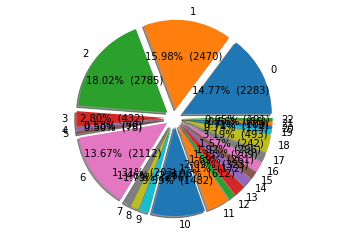

In [36]:
plot_pie(np.array(data['Category_Last']))

In [85]:
data['Category_Last'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [28]:
data['Category_Last'].unique()

array(['Banking Applications & Software-FINSOFT',
       'Banking Applications & Software-BOSS',
       'Banking Applications & Software-XNext',
       'Banking Applications & Software-Head Office Application',
       'Banking Applications & Software-Boss',
       'Banking Applications & Software-TCR (Teller Cash Recycler)',
       'Field Service-PC', 'Field Service-Skype for Business',
       'Field Service-Scanner', 'Field Service-MobileIron',
       'Field Service-Diğer', 'Field Service-Printer',
       'Field Service-I-Matic', 'Field Service-IngKey',
       'Field Service-Pulse Secure', 'Field Service-Glif',
       'Field Service-Email', 'Field Service-Vmware Harizon (Sanal PC)',
       'Field Service-Software', 'Field Service-Atm',
       'Field Service-Cisco Anyconnect', 'Field Service-Neoway',
       'Field Service-Tablet'], dtype=object)